In [23]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Mass_richness_relation as mass_richness
import analysis_Mass_Richness_relation as analysis



import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
flex = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/MCMC_chains/nfw_Diemer15_flex.pkl', allow_pickle=True)
bpz = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/MCMC_chains/nfw_Diemer15_bpz.pkl', allow_pickle=True)
true = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/MCMC_chains/nfw_Diemer15_true.pkl', allow_pickle=True)

In [25]:
label_plot = flex['label']

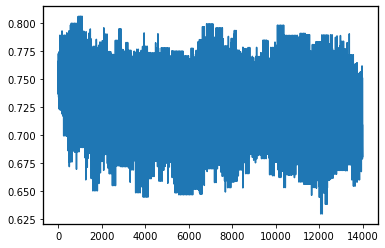

In [26]:
plt.plot(flex['chains'][:,2])

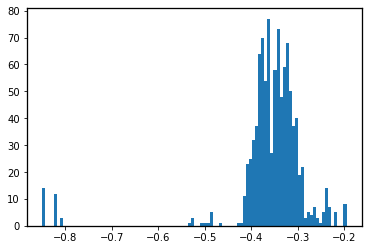

In [27]:
plt.hist(flex['chains'][:,1][13000:], bins=100
        )
plt.show()

In [34]:
k =flex['chains']
a = len(k)
middle = np.mean(k[10000:a-1], axis = 0)
std = np.std(k[10000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 3*std[i], middle[i]+ 3*std[i]) for i in range(4)]
range_corner_plot[-1] = (0,.5)

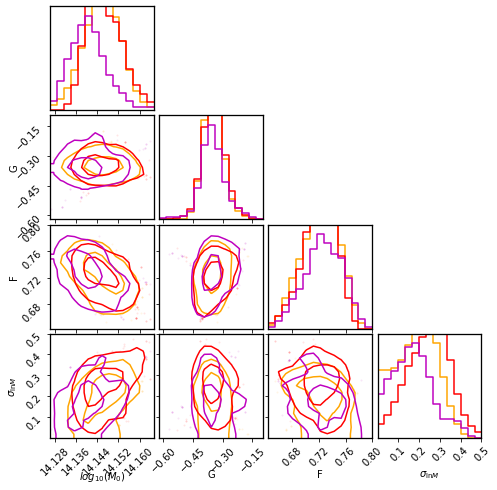

In [37]:
plt.rcParams['axes.linewidth'] = 1.3
labels_param = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 15
c = ['orange', 'r', 'm', 'k','k']
show = [True, True, True, True, True]
fill_contours = [False, False, False, False,  False]
fig, axs = plt.subplots(4,4, figsize = (7,7))

for i,sample in enumerate([ true, flex, bpz ]):
    s = sample['chains'][13500:]
    fig = corner.corner(
    s[s[:,1]>-.6],fig=fig,smooth=True, smooth1d=True,
    bins=bins, levels=(sigma1, sigma2), color=c[i],fill_contours=False,
        range=range_corner_plot,plot_density=False,
        #truths = [14.14658711, -0.33866985,  0.80118873,  0.46037449],
    labels = label_plot);
#plt.savefig('effect_modelling_mass_concentration.png', bbox_inches='tight', dpi=300)

In [64]:
mr = mass_richness.WL_Mass_Richness()
mr.set_pivot_values(analysis.z0, analysis.richness0)

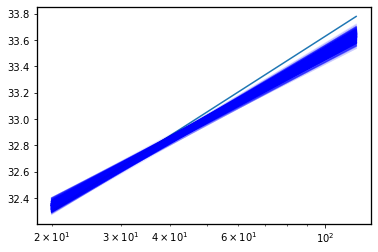

In [65]:
z_test = .4
true = [14.14838144, -0.2715481,  0.82636465]
richness = np.linspace(20, 120, 100)
mu = mr.lnM(richness, z_test, true)
plt.plot(richness, mu)
for p in Diemer15['chains'][13000:]:
    mu = mr.lnM(richness, z_test, p[0:-1])
    plt.plot(richness, mu, alpha=.1, c='b')
plt.xscale('log')